### In this notebook, we’ll take a corpus of Shakespeare sonnets, and use them to train a model with LSTM. Then, see if that model can create poetry!

In [8]:
# import required libraries
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 
import matplotlib.pyplot as plt

In [ ]:
# import data

# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
#     -O /Users/tanuj/Natural-Language-Processing-in-TensorFlow/Shakespeare_dataset/sonnets.txt

In [3]:
# Initialize the Tokenizer
tokenizer = Tokenizer()
# Read the Shakespeare dataset
data = open('Shakespeare_dataset/sonnets.txt').read()
# Convert the dataset to lowercase and split it into lines
corpus = data.lower().split("\n")
# Fit the tokenizer on the corpus. This will create a word index based on the corpus
tokenizer.fit_on_texts(corpus)
# Get the total number of unique words in the corpus
# Adding 1 because index starts from 1
total_words = len(tokenizer.word_index) + 1
input_sequences = []

for line in corpus:
    # Convert the line to a sequence of tokens
    token_list = tokenizer.texts_to_sequences([line])[0]
    # Create n-gram sequences from the token list
    for i in range(1, len(token_list)):
        # Create sequences of tokens up to the current position
        n_gram_sequence = token_list[:i+1]
        # Add the sequence to the list of input sequences
        input_sequences.append(n_gram_sequence)
# Find the maximum sequence length
max_sequence_len = max([len(x) for x in input_sequences])
# Pad sequences to ensure they are all the same length
# Padding is done at the beginning of the sequences
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
# predictors (input data) and label (output data)
# Predictors are all but the last token in each sequence
predictors, label = input_sequences[:,:-1], input_sequences[:,-1]
# Convert labels to one-hot encoding. needed for categorical prediction
label = ku.to_categorical(label, num_classes=total_words)

In [4]:
# Initialize a sequential model
model = Sequential()
# The embedding layer maps each word/token to a vector representation
# total_words: total number of unique words in the vocabulary
# 100: size of the embedding vector for each word
# max_sequence_len-1: length of input sequences excluding the label
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
# Bidirectional LSTM processes the input sequence in both forward and backward directions
# 150: number of LSTM units/neurons
# return_sequences=True: returns the full sequence output
model.add(Bidirectional(LSTM(150, return_sequences=True)))
# Dropout is a regularization technique to prevent overfitting
# 0.2: fraction of input units to drop during training
model.add(Dropout(0.2))
# This LSTM layer processes the output sequences from the previous layer
# 100: number of LSTM units/neurons
model.add(LSTM(100))
# Add a dense layer with ReLU activation
# total_words/2: number of neurons in the dense layer
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# This layer outputs the probability distribution over the vocabulary
# total_words: number of neurons equal to the vocabulary size
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Print model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 100)           321100    
                                                                 
 bidirectional (Bidirectiona  (None, 10, 300)          301200    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 10, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1605)              162105    
                                                                 
 dense_1 (Dense)             (None, 3211)              5156866   
                                                        

In [5]:
history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 57s 70ms/step - loss: 6.9069 - accuracy: 0.0194
Epoch 2/100
484/484 [==============================] - 22s 46ms/step - loss: 6.4989 - accuracy: 0.0229
Epoch 3/100
484/484 [==============================] - 9s 18ms/step - loss: 6.4032 - accuracy: 0.0236
Epoch 4/100
484/484 [==============================] - 9s 18ms/step - loss: 6.2791 - accuracy: 0.0303
Epoch 5/100
484/484 [==============================] - 8s 17ms/step - loss: 6.1836 - accuracy: 0.0366
Epoch 6/100
484/484 [==============================] - 8s 17ms/step - loss: 6.1053 - accuracy: 0.0385
Epoch 7/100
484/484 [==============================] - 9s 18ms/step - loss: 6.0348 - accuracy: 0.0402
Epoch 8/100
484/484 [==============================] - 9s 18ms/step - loss: 5.9494 - accuracy: 0.0433
Epoch 9/100
484/484 [==============================] - 9s 18ms/step - loss: 5.8496 - accuracy: 0.0493
Epoch 10/100
484/484 [==============================] - 9s 18ms/step - loss: 5.7

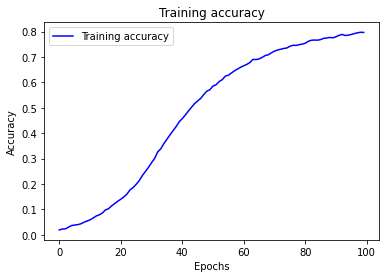

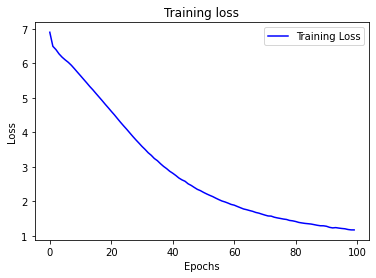

In [9]:
# Extract training accuracy and loss from the history object
acc = history.history['accuracy'] 
loss = history.history['loss']  
# Create a range of epochs for plotting
epochs = range(len(acc))
# Plot training accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.xlabel('Epochs')  
plt.ylabel('Accuracy')  
plt.legend()  

# Create a new figure for plotting training loss
plt.figure()
# Plot training loss
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend()  

# Display the plots
plt.show()

give a set of words(phrase) and predict next 100 words

In [13]:
# Initial seed text for text generation
seed_text = "Help me Obi Wan Kenobi, you're my only hope"

# Number of words to generate
next_words = 100

for _ in range(next_words):
    # Convert the seed text to a sequence of tokens
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    # Pad the token sequence to match the model's input length
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    # Predict the probabilities for each word using the trained model
    predicted_probs = model.predict(token_list, verbose=0)[0]
    # Get the index of the word with the highest probability
    predicted_index = np.argmax(predicted_probs)
    # Convert the predicted index to the corresponding word
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted_index:
            output_word = word
            break
    # Append the predicted word to the seed text for the next iteration
    seed_text += " " + output_word

# Print the generated text
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope when them i die die die see bright bright bright day day before words days outworn live day o'er brow brow day me live worth before for till bright now bring false eyes before eyes who live happy dyed bright dwell ' write grace that other bright young young days bright live young of friend bright bright young die live bright bright young light bright tongue taken bright tell men age in me more bright now live young me bright bright young live ruining outworn every state bright hate bright bright die sits gems hits outworn confounds tell all men
